# Exercise 1 on Clustering and Local PCA

The goal of the exercise is to perform perform clustering on a dataset representing a noisy 2D non-linear function.
* How do we select the correct number of clusters?
* Why LPCA works better than PCA on a non-linear dataset?

First thing, we create our synthetic dataset

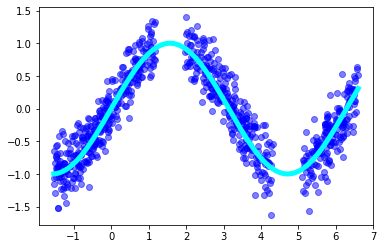

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

def non_linear_func_orig(x):
    y = np.sin(x)
    return y

def non_linear_func(x):
    y = np.sin(x) + 0.25*np.random.randn(x.size) 
    return y
    
# This code is used to create our synthetic dataset
size = 1000
seed = 42
np.random.seed(seed)

x = np.random.rand(size) * 2.6*np.pi - np.pi/2
y = non_linear_func(x)

limits = [np.pi/2, 3/2*np.pi]
eps = np.pi/8

mask = ((x < limits[0] + eps) & (x > limits[0] - eps)) | (x < limits[1] + eps) & (x > limits[1] - eps)
x = x[~mask]
y = y[~mask]

X = np.zeros((x.size, 2))
X[:,0] = x
X[:,1] = y

x_orig = np.linspace(x.min(), x.max(), 200)
y_orig = np.sin(x_orig)

# We can plot the dataset and the original non-linear function
plt.scatter(X[:,0], X[:,1], c='b', alpha=0.5)
plt.plot(x_orig, y_orig, c='cyan', lw=5)
plt.show()


## Global PCA
Now we apply the PCA and try to reconstruct the dataset using only one dimension.

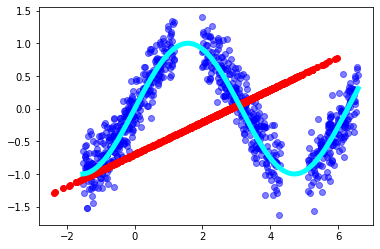

In [4]:
# We import the PCA object from the sklearn package
from sklearn.decomposition import PCA

cnt = np.mean(X, axis=0)
scl = np.std(X, axis=0)
X0 = (X - cnt)/ scl

pca = PCA()
pca.fit(X0)

A = pca.components_.T
Z = X0 @ A

q = 1 # we select only one PC
X0_rec = Z[:,:q] @ A[:,:q].T
X_rec = scl * X0_rec + cnt

plt.scatter(X[:,0], X[:,1], c='b', alpha=0.5)
plt.plot(x_orig, y_orig, c='cyan', lw=5)
plt.scatter(X_rec[:,0], X_rec[:,1], c='red')
plt.show()


## Clustering

We can try and improve the reconstruction accuracy using a local approach. The first thing to do is then to cluster the dataset using kmeans.

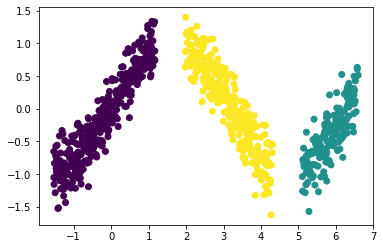

In [5]:
# We import the KMEANS object from the sklearn package
from sklearn.cluster import KMeans
k = 3
kmeans = KMeans(n_clusters=k, init='random')
kmeans.fit(X)
labels = kmeans.labels_

# We plot the data coloured by cluster label
plt.scatter(X[:,0], X[:,1], c=labels)
plt.show()


## Selection of the clusters' number

In this case we can visually identify the number of clusters, because we have only two dimensions. In higher dimensions, it is not possible to visualize the dataset. Also, we would prefer to have an automatic method to select the correct number of clusters.

We can use the Devies Bouldin score to estimate the number of clusters.


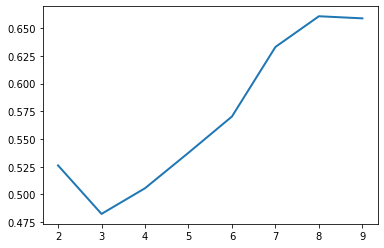

In [6]:
from sklearn.metrics import davies_bouldin_score

# We compute the DB score for different number of clusters k and we look for the minimum.
k_array = np.arange(2,10)
db_score_array = np.zeros((k_array.size,)) 

for i, k in enumerate(k_array):
    kmeans = KMeans(n_clusters=k, init='random')
    kmeans.fit(X)
    labels = kmeans.labels_
    db_score = davies_bouldin_score(X, labels)
    db_score_array[i] = db_score

n_clusters = k_array[np.argmin(db_score_array)]

plt.plot(k_array, db_score_array, lw=2)
plt.show()


## Local PCA

Now we can apply the PCA in each cluster.

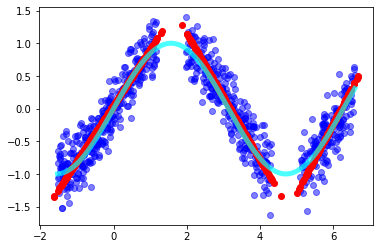

In [9]:
# first we compute Kmeans to find the labels with the correct number of clusters
kmeans = KMeans(n_clusters=n_clusters, init='random')
kmeans.fit(X)
labels = kmeans.labels_

pca = PCA()

# the for cycle is used to fit the PCA model in each cluster
for k in range(n_clusters):
    mask = (labels == k)
    X_k = X[mask] # the mask is used to select the clusters with a specific label
    cnt_k = np.mean(X_k, axis=0)
    scl_k = np.std(X_k, axis=0)
    X0_k = (X_k - cnt_k)/scl_k # we need to center the data in each cluster
    pca.fit(X0_k)
    A_k = pca.components_.T
    Z_k = X0_k @ A_k
    X0_k_rec = Z_k[:,:q] @ A_k[:,:q].T 
    X_k_rec = scl_k * X0_k_rec + cnt_k
    plt.scatter(X_k[:,0], X_k[:,1], c='b', alpha=0.5)
    plt.scatter(X_k_rec[:,0], X_k_rec[:,1], c='r')

plt.plot(x_orig, y_orig, c='cyan', lw=5, alpha=0.7)
plt.show()

## Local PCA with VQPCA

We can compare the KMEANS results with VQPCA. To perform VQPCA, we need the [OpenMORe](https://github.com/burn-research/OpenMORe) library. You can run the next cell to install it. 

In [10]:
!git clone https://github.com/burn-research/OpenMORe.git

import sys

sys.path.insert(0,'/content/OpenMORe')

import OpenMORe

Cloning into 'OpenMORe'...
remote: Enumerating objects: 1444, done.
remote: Counting objects: 100% (222/222), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 1444 (delta 135), reused 142 (delta 65), pack-reused 1222
Receiving objects: 100% (1444/1444), 16.37 MiB | 3.85 MiB/s, done.
Resolving deltas: 100% (1020/1020), done.


In [11]:
import OpenMORe.clustering as clustering

# This is a dictionary used to set the VQPCA parameters.
settings_clustering = {
    #centering and scaling options
    "center"                    : True,
    "centering_method"          : "mean",
    "scale"                     : True,
    "scaling_method"            : "auto",

    #set the initialization method (random, observations, kmeans, pkcia, uniform)
    "initialization_method"     : "random",

    #set the number of clusters and PCs in each cluster
    "number_of_clusters"        : 3,
    "number_of_eigenvectors"    : 1,

    #enable additional options:
    "correction_factor"         : "off",    # --> enable eventual corrective coefficients for the LPCA algorithm:
                                            #     'off', 'c_range', 'uncorrelation', 'local_variance', 'phc_multi', 'local_skewness' are available

    "classify"                  : False,    # --> call the method to classify a new matrix Y on the basis of the lpca clustering
    "write_on_txt"              : False,    # --> write the idx vector containing the label for each observation
    "evaluate_clustering"       : True,     # --> enable the calculation of indeces to evaluate the goodness of the clustering
    "neighbors_number"          : 0,
}

# First we create the model and then we fit it to the dataset
model = clustering.lpca(X, settings_clustering)
labels_vqpca = model.fit()


Preprocessing training matrix..
Fitting Local PCA model...
- Iteration number: 1
	Reconstruction error: 0.17309759588874704
	Reconstruction error variance: 4.77708774559017
- Iteration number: 2
	Reconstruction error: 0.10797641708514578
	Reconstruction error variance: 0.6031055721384916
- Iteration number: 3
	Reconstruction error: 0.0835234062934339
	Reconstruction error variance: 0.29276836131184253
- Iteration number: 4
	Reconstruction error: 0.07548597890302959
	Reconstruction error variance: 0.10647576552897721
- Iteration number: 5
	Reconstruction error: 0.06973320143206777
	Reconstruction error variance: 0.08249696490080155
- Iteration number: 6
	Reconstruction error: 0.06283440278582252
	Reconstruction error variance: 0.1097933351855114
- Iteration number: 7
	Reconstruction error: 0.057299909878506576
	Reconstruction error variance: 0.09658816076763053
- Iteration number: 8
	Reconstruction error: 0.05309588351975924
	Reconstruction error variance: 0.07917800929299602
- Iteratio

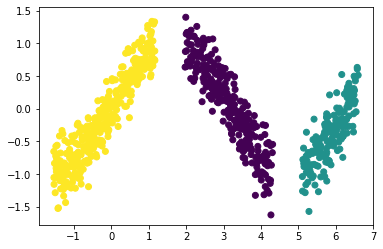

In [12]:
# Now we can plot the clusters
plt.scatter(X[:,0], X[:,1], c=labels_vqpca)
plt.show()
